# Traffic Sign Recognition using CNN

## 1. Project Overview
**Goal:** Build an end-to-end CNN that recognizes traffic sign images into **43 classes**.

**Steps covered in this notebook:**
- Load & inspect the dataset (Train/Test + CSVs)
- Preprocess images: **Grayscale → CLAHE → Normalize → Reshape**
- Build a compact CNN
- Train with **EarlyStopping**
- Evaluate with **Confusion Matrix + Classification Report**
- Save the trained model

**Why this matters:** robust traffic sign recognition is a core block for ADAS / self-driving systems.

---


## 2. Setup & Data Access
We’re using **Google Colab + Google Drive**:
- Mount Drive
- Unzip the dataset to `/content/traffic_sign_data`

**Paths:**
- Train images → `/content/traffic_sign_data/Train`
- Test images → `/content/traffic_sign_data/Test`
- CSVs → `Train.csv`, `Test.csv`, `signnames.csv`

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Traffic_sign_recognition/data.zip'
extract_path = '/content/traffic_sign_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

train_dir = os.path.join(extract_path, 'Train')
test_dir = os.path.join(extract_path, 'Test')
train_csv = os.path.join(extract_path, 'Train.csv')
test_csv = os.path.join(extract_path, 'Test.csv')
signnames_csv = os.path.join(extract_path, 'signnames.csv')

print('Train folder:',train_dir)
print('Test folder:',test_dir)
print('CSV files:',train_csv,test_csv,signnames_csv)

Train folder: /content/traffic_sign_data/Train
Test folder: /content/traffic_sign_data/Test
CSV files: /content/traffic_sign_data/Train.csv /content/traffic_sign_data/Test.csv /content/traffic_sign_data/signnames.csv


## 3. Load Images (Train/Test)
**Steps:**
- Iterate folders `Train/0 … Train/42`, resize to **30×30**, label from folder name
- Load **Test set** using `Test.csv`, fix paths, resize

**Outputs:**
- `X_train, y_train`
- `X_test, y_test`

In [19]:
import cv2

IMG_HEIGHT , IMG_WIDTH = 30,30

def load_training_data(train_dir):
  images = []
  labels = []

  for class_id in range(43):
      class_path = os.path.join(train_dir, str(class_id))
      for img_file in os.listdir(class_path):
          img_path = os.path.join(class_path, img_file)
          try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            images.append(img)
            labels.append(class_id)
          except Exception as e:
            print('Error loading images',img_file,e)

  images = np.array(images)
  labels = np.array(labels)
  return images,labels

X_train,y_train = load_training_data(train_dir)

print('Training data shape:',X_train.shape,y_train.shape)

Training data shape: (39209, 30, 30, 3) (39209,)


In [20]:
test_csv = "/content/traffic_sign_data/Test.csv"

# Load CSV
test_df = pd.read_csv(test_csv)

# Fix the paths (replace wrong '/code/' with actual '/content/traffic_sign_data/')
test_df['Path'] = test_df['Path'].apply(lambda x: x.replace('/code/', '/content/traffic_sign_data/'))

# Function to load test data
def load_test_data(df, img_size=(30,30)):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = row['Path']
        label = row['ClassId']
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read: {img_path}")
            continue
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

# Load test images
X_test, y_test = load_test_data(test_df)
print("Test data shape:", X_test.shape, y_test.shape)


Test data shape: (12630, 30, 30, 3) (12630,)


## 4. Quick EDA
- Plot **class distribution**
- Show **sample images** from random classes

**Why:** check for imbalance or mislabels before training.

Number of classes: 43
Class distribution(training):
Class 0: 210 samples
Class 1: 2220 samples
Class 2: 2250 samples
Class 3: 1410 samples
Class 4: 1980 samples
Class 5: 1860 samples
Class 6: 420 samples
Class 7: 1440 samples
Class 8: 1410 samples
Class 9: 1470 samples
Class 10: 2010 samples
Class 11: 1320 samples
Class 12: 2100 samples
Class 13: 2160 samples
Class 14: 780 samples
Class 15: 630 samples
Class 16: 420 samples
Class 17: 1110 samples
Class 18: 1200 samples
Class 19: 210 samples
Class 20: 360 samples
Class 21: 330 samples
Class 22: 390 samples
Class 23: 510 samples
Class 24: 270 samples
Class 25: 1500 samples
Class 26: 600 samples
Class 27: 240 samples
Class 28: 540 samples
Class 29: 270 samples
Class 30: 450 samples
Class 31: 780 samples
Class 32: 240 samples
Class 33: 689 samples
Class 34: 420 samples
Class 35: 1200 samples
Class 36: 390 samples
Class 37: 210 samples
Class 38: 2070 samples
Class 39: 300 samples
Class 40: 360 samples
Class 41: 240 samples
Class 42: 240 sam

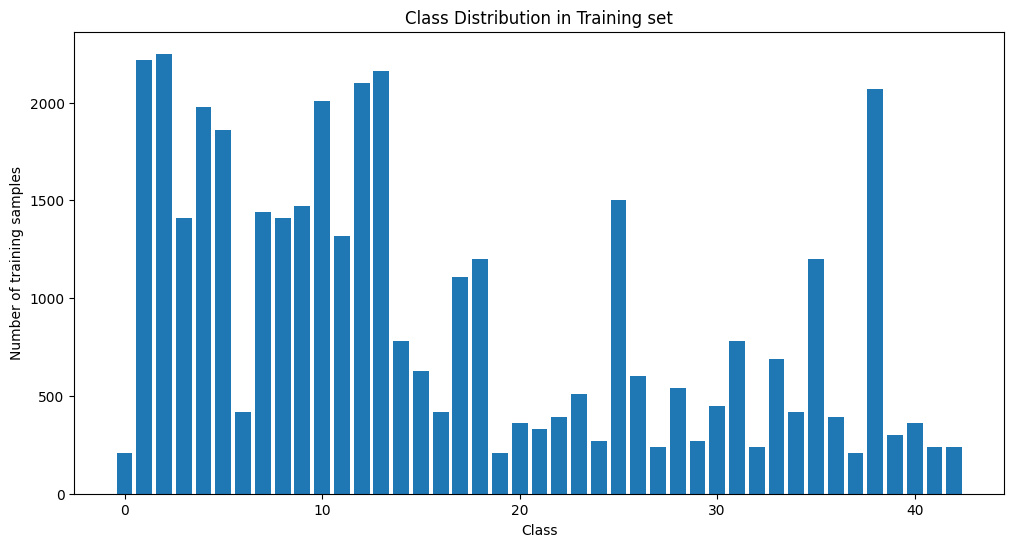

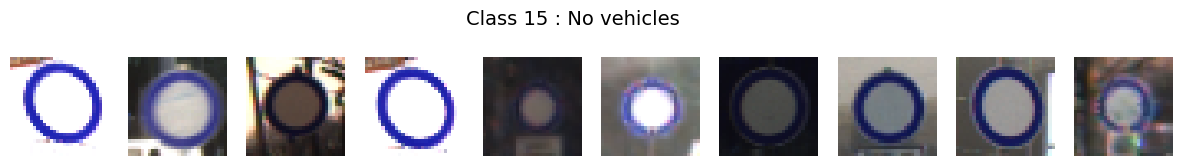

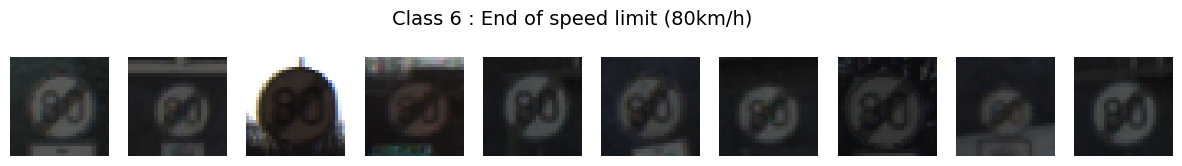

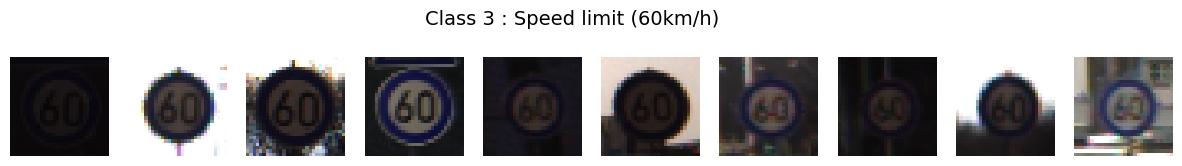

In [21]:
import random

classes, counts = np.unique(y_train,return_counts = True)

print('Number of classes:',len(classes))
print('Class distribution(training):')

for c,count in zip(classes,counts):
  print(f'Class {c}: {count} samples' )

plt.figure(figsize = (12,6))
plt.bar(classes,counts)
plt.xlabel('Class')
plt.ylabel('Number of training samples')
plt.title('Class Distribution in Training set')
plt.show()

def show_samples(X,y,class_id,class_name , n = 10):
  indices = np.where(y == class_id)[0]
  selected = random.sample(list(indices),n)
  fig,axes = plt.subplots(1,n,figsize = (15,2))
  for i,idx in enumerate(selected):
    axes[i].imshow(X[idx])
    axes[i].axis('off')
  fig.suptitle(f'Class {class_id} : {class_name}',fontsize = 14)
  plt.show()

signnames = pd.read_csv('/content/traffic_sign_data/signnames.csv')

for c in random.sample(list(classes),3):
  show_samples(X_train,y_train,c,signnames.loc[c,'SignName'])

## 5. Preprocessing Pipeline
1. **Grayscale:** reduce complexity, keep shape/edges  
2. **CLAHE:** boost contrast under poor lighting  
3. **Normalize:** scale pixels **0–255 → 0–1**  
4. **Reshape:** final shape = `(N, 30, 30, 1)`


In [22]:
#convert to grayscale

def rgb_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

X_train_gray = rgb_to_gray(X_train)
X_test_gray  = rgb_to_gray(X_test)

print("Grayscale training shape:", X_train_gray.shape)
print("Grayscale testing shape:", X_test_gray.shape)


Grayscale training shape: (39209, 30, 30)
Grayscale testing shape: (12630, 30, 30)


In [23]:
#apply clahe (Contrast Limited Adaptive Histogram Equalization)

def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_images = np.array([clahe.apply(img) for img in images])
    return enhanced_images

X_train_clahe = apply_clahe(X_train_gray)
X_test_clahe  = apply_clahe(X_test_gray)

print("CLAHE applied on training:", X_train_clahe.shape)
print("CLAHE applied on testing:", X_test_clahe.shape)


CLAHE applied on training: (39209, 30, 30)
CLAHE applied on testing: (12630, 30, 30)


In [24]:
# Normalize (scale pixels 0-255 -> 0-1)

X_train_norm = X_train_clahe/255
X_test_norm = X_test_clahe/255

print('Normalized range:',X_train_norm.min(),X_train_norm.max())
print('Normalized shapes:',X_train_norm.shape,X_test_norm.shape)

Normalized range: 0.01568627450980392 1.0
Normalized shapes: (39209, 30, 30) (12630, 30, 30)


In [25]:
# Reshaping

X_train_final = X_train_norm.reshape(-1, 30, 30, 1)
X_test_final  = X_test_norm.reshape(-1, 30, 30, 1)

print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)


Final train shape: (39209, 30, 30, 1)
Final test shape: (12630, 30, 30, 1)


## 6. Model Architecture (Simple & Clear)
**Layers:**
- Conv2D(32, 3×3) + MaxPool
- Conv2D(64, 3×3) + MaxPool
- Conv2D(128, 3×3) + MaxPool
- Flatten
- Dense(128, ReLU)
- Dropout(0.6)
- Dense(43, Softmax)

**Explanation (no heavy math):**
- Conv → learns shapes/edges  
- Pool → reduces size, keeps strongest features  
- Flatten → converts features to 1D  
- Dense → decision-making  
- Dropout → prevents overfitting  
- Softmax → final probabilities across 43 classes

**Loss/Optimizer:**
- `sparse_categorical_crossentropy`
- `adam`

In [26]:
#Importing Libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [27]:
# Creating Model
model = Sequential()

# Adding the Convolution Layers
#1st Convolution + Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

#2nd Convolution + Pooling

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#3rd Convolution + Pooling

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Adding Flatten and Dense Layers
#Flatten Converts 3D -> 1D
model.add(Flatten())

#Fully Connected layer
model.add(Dense(128, activation='relu'))

#Dropout to prevent overfitting
model.add(Dropout(0.6))

#Output Layer
model.add(Dense(43, activation='softmax'))

#Complie the Model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,883 (640.17 KB)

 Trainable params: 163,883 (640.17 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Training Setup
- Epochs: `100`
- Batch size: `64`
- **EarlyStopping** (patience=5, monitor=val_loss, restore best weights)

**Why:** prevents overfitting & wasted compute.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_final, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_final, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2261 - loss: 2.8869 - val_accuracy: 0.8436 - val_loss: 0.5497
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7792 - loss: 0.7019 - val_accuracy: 0.9235 - val_loss: 0.2686
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8724 - loss: 0.3995 - val_accuracy: 0.9441 - val_loss: 0.1987
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9161 - loss: 0.2684 - val_accuracy: 0.9448 - val_loss: 0.1899
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9325 - loss: 0.2093 - val_accuracy: 0.9517 - val_loss: 0.1616
Epoch 6/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9439 - loss: 0.1710 - val_accuracy: 0.9499 - val_loss: 0.1844
Epoch 7/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9514 - loss: 0.1498 - val_accuracy: 0.9550 - val_loss: 0.1838
Epoch 8/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9576 - loss: 0.1269 - val_acc

## 8. Training Curves
We plot:
- **Train vs Validation Accuracy**
- **Train vs Validation Loss**

**Interpretation:**
- Both accuracies rising together = good
- Validation stalling/dropping while train rises = overfitting
- Loss should steadily decrease (small wiggles are fine)

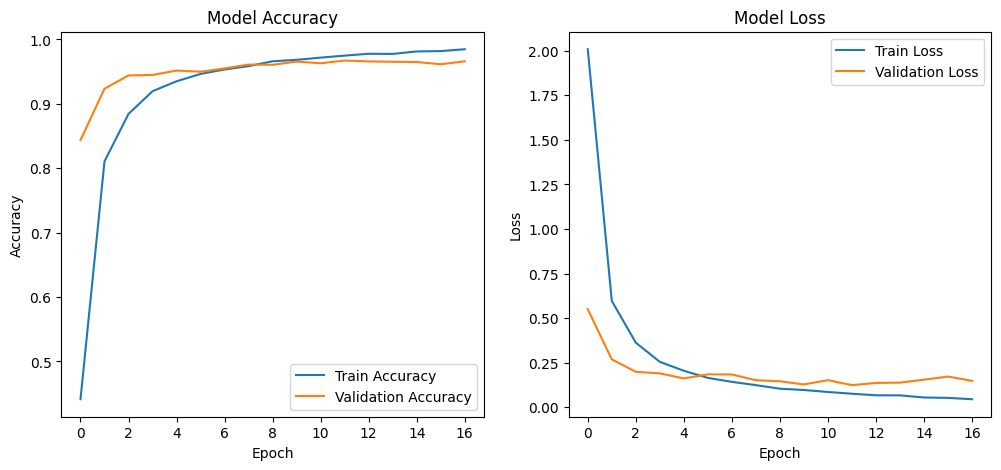

In [29]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 9. Evaluation
**Metrics:**
- Predictions on test set
- **Confusion Matrix**
- **Classification Report (Precision, Recall, F1)**

**Use case:**
- Classes with low recall → signs often missed  
- Classes with low precision → too many false alarms

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
cr = classification_report(y_test, y_pred_classes)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Confusion Matrix:
[[ 56   0   0 ...   0   0   0]
 [  0 702   5 ...   0   0   0]
 [  0   2 745 ...   0   0   0]
 ...
 [  0   3   0 ...  80   0   0]
 [  0   0   0 ...   0  46   0]
 [  0   0   0 ...   0   2  84]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.99      0.97      0.98       720
           2       0.98      0.99      0.99       750
           3       0.95      0.96      0.96       450
           4       0.98      0.99      0.98       660
           5       0.93      0.95      0.94       630
           6       0.98      0.96      0.97       150
           7       0.97      0.97      0.97       450
           8       0.97      0.94      0.96       450
           9       0.97      1.00      0.98       480
          10       1.00      0.99      0.99       660
          11       0.94      0.93      0.93       420
          12       0.9

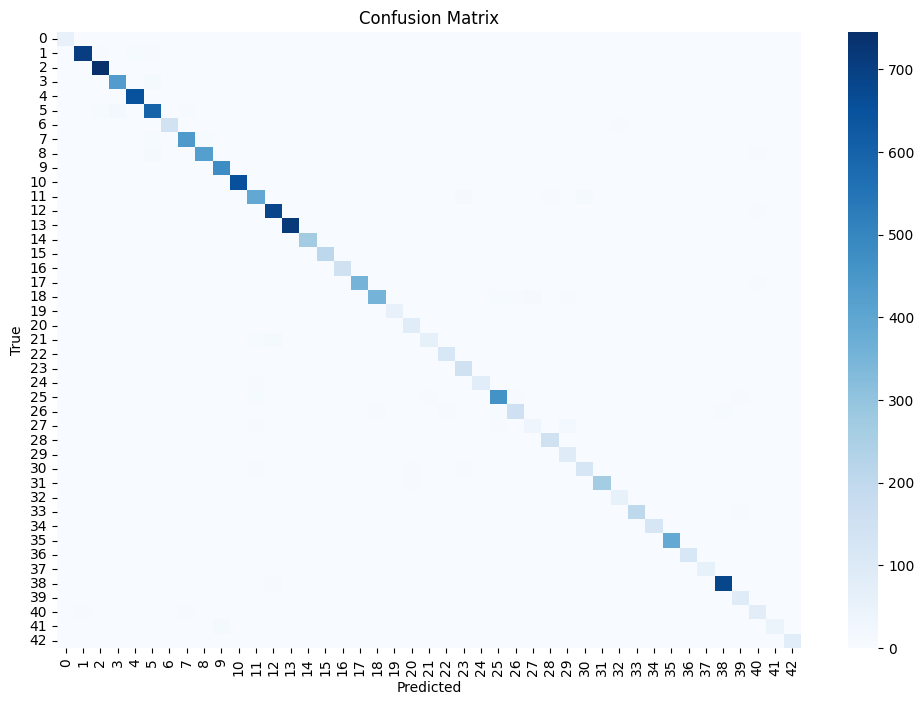

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 10. Save the Model
We save final model as: traffic_sign_model.h5

In [37]:
#Saving the model
from tensorflow.keras.models import save_model
model.save('traffic_sign_model.h5')
print('Model saved as traffic_sign_model.h5')

Model saved as traffic_sign_model.h5


In [38]:
from google.colab import files
files.download("traffic_sign_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Conclusion

In this project, we successfully built and trained a **Convolutional Neural Network (CNN)** to classify traffic signs into 43 categories with an accuracy of around **96–97%** on the test set.  

Our preprocessing pipeline — **grayscale conversion, CLAHE enhancement, and normalization** — proved effective in simplifying input data while preserving important features. We experimented with data augmentation but found that it did not significantly improve accuracy for this dataset, so we focused on stability and reproducibility instead.  

Key achievements:
- Designed a compact yet powerful CNN with dropout and early stopping to prevent overfitting.  
- Reached high accuracy while keeping the model lightweight enough for real-world deployment.  
- Performed detailed evaluation using **confusion matrix** and **classification report**, identifying classes where performance could be further improved.  
- Saved the trained model (`traffic_sign_model.h5`) for easy reuse or deployment.  

This demonstrates how a carefully designed CNN, combined with targeted preprocessing, can deliver strong performance in traffic sign recognition — an important task for autonomous driving and road-safety applications.
